<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Math_Model_Draft_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
pd.options.display.max_rows = 999

### Actual Data From <font color=#800000> Italy</font>

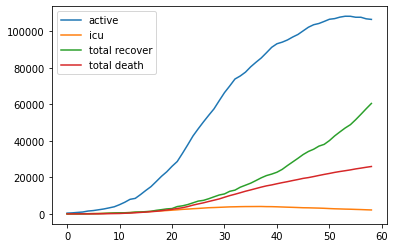

In [0]:
df_Italy = pd.read_excel('https://github.com/akhavan12/discrete_covid_model/raw/master/Country_Trends.xlsx',sheet_name='Italy')
#df_Italy[['total case','icu','total recover','total death']]
df_Italy[['active','icu','total recover','total death']].plot()

## parameters

In [0]:
# e : epsilon # delay of exposed to infections
# ## recovery rate form a, m , w, v
# R_a : recovery from gamma_asympt
# R_m : recovery from gamma_mild
# R_w : recovery from gamma_Severe
# R_v : recovery from gamma_ventilator
# ## death rate from w and v
# eta_w: death when eta_w severe
# eta_v: death when eta_v ventilator
# ## Bilinear incidence (infected cases, transmitting the virus)
# B : beta infection rate 
# ## moving from 1 state to another
# G_a : omega_a move from state Asympt to Mild
# G_m : omega_m move from state Mild to Severe
# G_w : omega_w move from state Severe to Ventilator

In [0]:
### Population

In [0]:
N = 60e6 ##  60 Million

In [0]:
IC= {}
params = {}
t=np.array([])

# Total population, N.

# initial conditions
def initialize():
    global t
    global N
    global IC
    global params
    
    y0 = IC['H0'], IC['E0'], IC['A0'], IC['M0'], IC['W0'], IC['V0'], IC['R0'], IC['D0'],IC['T0']

    return y0

### Funcions

In [0]:
def deriv(y, t, N,params):
    H, E, A, M, W, V, R, D, T = y
    e =params["e"] # sym.symbols('epsilon') # delay of exposed to infections
    ## infection rate from M and A
    ## recovery rate form a, m , w, v
    R_a = params['R_a'] # recovery from gamma_asympt
    R_m = params['R_m'] # recovery from gamma_mild
    R_w = params['R_w'] # recovery from gamma_Severe
    R_v = params['R_v'] # recovery from gamma_ventilator
    ## death rate from w and v
    eta_w = params['eta_w'] # death when eta_w severe
    eta_v = params['eta_v'] # death when eta_v ventilator
    ## Bilinear incidence (infected cases, transmitting the virus)
    B = params['B']  # beta infection rate 
    ## moving from 1 state to another
    G_a = params['G_a']  # omega_a move from state Asympt to Mild
    G_m = params['G_m'] # omega_m move from state Mild to Severe
    G_w = params['G_w'] # omega_w move from state Severe to Ventilator

    alpha_test= params['alpha_test'] # Ratio of tested People in A --> M
    alpha_test_1_positive= params['alpha_test_1_positive'] # ratio of Positive test 1
    #alpha_test_2_positive= params['alpha_test_2_positive'] # ratio of Positive test 2 (after severe)
    
    dHdt =  -B * H*(A+M+W)/N  +  G_a * A * alpha_test*(1-alpha_test_1_positive)  ## a the infected population is deducted fromt he healty population
    
    dEdt =  B * H*(A+M+W)/N - (e * E ) ## Exposed population - infected population
     
    dAdt =  e * E  - (G_a * A) - (R_a * A) ## Asymptomatic 
    
    dTestdt = G_a * A * alpha_test 
    
    dMdt =  G_a * A * alpha_test*(alpha_test_1_positive) +\
            G_a * A * (1-alpha_test) +\
            - (G_m * M) - (R_m * M) ## Mild 
    
    dWdt =  G_m * M - (G_w * W) - (R_w * W) - (eta_w * W) ## Severe
    
    dVdt =  G_w * W - (R_v * V) - (eta_v * V) ## Ventilator 
    
    dRdt =  R_a * A + R_m * M + R_w * W + R_v* V ## Recovered
    
    dDdt =  (eta_w * W) + (eta_v * V) ## Dead

    return dHdt, dEdt, dAdt, dMdt, dWdt, dVdt, dRdt, dDdt,dTestdt

In [0]:
def Simulate(params=params):
    y0 = IC['H0'], IC['E0'], IC['A0'],\
         IC['M0'], IC['W0'], IC['V0'], \
         IC['R0'], IC['D0'], IC['T0']
    ret = odeint(deriv, y0, t,args=(N,params,))#, args=(N, beta, gamma))
    H, E, A, M, W, V, R, D,T = ret.T
    return ret.T

In [0]:
### initialize the parameters

In [0]:
results=[]
t = np.linspace(-28, 100, 100)
IC={
    "H0" : N,
    "E0" : 500, 
    "A0" : 430,
    "M0" : 650,
    "W0" : 20,
    "V0" : 56,
    "R0" : 45,
    "D0" : 5,
    "T0" : 12014
    }

params={
    "e" :    .1,
    "B" :    .8,  
    "R_a" :  0.08,
    "R_m" :  0.80,
    "R_w" :  0.7, 
    "R_v" :  0.2, 
    "G_a" :  .005,
    "eta_w": 0.03,
    "eta_v": 0.06, 
    "G_m" :  .22, 
    "G_w" :  0.05,
    "alpha_test" : .4,
    "alpha_test_1_positive" : .9
    }


In [0]:
## Interactive 2
from ipywidgets import FloatSlider


In [0]:
def Interactive_deriv(e,B,R_a,R_m,R_w,R_v,G_a,eta_w,eta_v,G_m,G_w,alpha_test,alpha_test_1_positive):
    params['e'] =    e
    params['B'] =    B
    params['R_a'] =  R_a
    params['R_m'] =  R_m
    params['R_w'] =  R_w
    params['R_v'] =  R_v
    params['G_a'] =  G_a
    params['eta_w']= eta_w
    params['eta_v']= eta_v
    params['G_m'] =  G_m
    params['G_w'] =  G_w
    params["alpha_test"] = alpha_test
    params["alpha_test_1_positive"] = alpha_test_1_positive
    initialize()
    res = Simulate(params).T
    Actual_Mild = df_Italy['active']-df_Italy['icu']
    
    Time_lag=-10
    
    
    df_res = pd.DataFrame(res,columns=['H','E','A','M','W','V','R','D','T']) 
    f,ax=plt.subplots(2,2,figsize=(10,8))
    axs=ax.ravel()
    ## Mild
    axs[0].plot(t+Time_lag,df_res["M"],label='Simulation',color='blue')
    axs[0].plot(Actual_Mild,label='Actual: Mild',color='black')
    axs[0].set_title('Mild')
    ## Recovered
    axs[1].plot(t-Time_lag,df_res["R"],label='Simulation',color='blue')
    axs[1].plot(df_Italy['total recover'],label='Actual: Mild',color='black')
    axs[1].set_title('Recovered')
    axs[1].set_xlim([0,70])
    axs[1].set_ylim([0,100000])
    ## Ventilator
    axs[2].plot(t+Time_lag,df_res["V"],label='Simulation',color='blue')
    axs[2].plot(df_Italy['icu'],label='Actual: icu',color='black')
    axs[2].set_title('Ventilation')
    
    ## Dead
    axs[3].plot(t+Time_lag,df_res["D"],label='Simulation',color='blue')
    axs[3].plot(df_Italy['total death'],label='Actual: Mild',color='black')
    axs[3].set_title('total death')
 

In [0]:
step_size=.01
w = interactive(Interactive_deriv, e=      FloatSlider(min=.01, max=1,   step=step_size, value=.06) 
                                  ,B =     FloatSlider(min=.01, max=1.5, step=step_size, value=0.81) 
                                  ,R_a =   FloatSlider(min=.01, max=.5,  step=step_size, value=0.08) 
                                  ,R_m =   FloatSlider(min=.01, max=3,   step=step_size, value=1.06) 
                                  ,R_w =   FloatSlider(min=.01, max=3,   step=step_size, value=0.86) 
                                  ,R_v =   FloatSlider(min=.01, max=3,   step=step_size, value=0.16) 
                                  ,G_a =   FloatSlider(min=.01, max=.1,   step=.001, value=0.01) 
                                  ,G_m   = FloatSlider(min=.01, max=3,   step=step_size, value=0.31)  
                                  ,G_w   = FloatSlider(min=.01, max=3,   step=step_size, value=0.07)
                                  ,eta_w = FloatSlider(min=.01, max=3,   step=step_size, value=0.03)  
                                  ,eta_v = FloatSlider(min=.01, max=3,   step=step_size, value=0.36)
                                  ,alpha_test = FloatSlider(min=.01, max=1, step=step_size, value=0.4) 
                                  ,alpha_test_1_positive = FloatSlider(min=.1, max=1, step=step_size, value=0.9) 
                                  )

In [0]:
from IPython.display import display
display(w)

interactive(children=(FloatSlider(value=0.06, description='e', max=1.0, min=0.01, step=0.01), FloatSlider(valu…